# spaCy and networkx

Date: 2023/11/24-2023/12/09, 2023/12/14

Reference: https://youtu.be/fAHkJ_Dhr50

ドイツに住んでいた頃、バッハの音楽を聴きながら生活したので、バッハの本を選んだ。

Free book "Johann Sebastian Bach: His Life, Art, and Work" from Project Gutenberg: https://www.gutenberg.org/ebooks/35041

In [1]:
import re

In [2]:
with open('../data/pg35041_.txt') as f:
    text_ = f.read()

text = re.sub(r'_*\(\d+\)|_', '', text_)
print(text[:3000])

CHAPTER I. THE FAMILY OF BACH


If there is such a thing as inherited aptitude for art it certainly showed
itself in the family of Bach. For six successive generations scarcely two
or three of its members are found whom nature had not endowed with
remarkable musical talent, and who did not make music their
profession.

Veit Bach, ancestor of this famous family, gained a livelihood as a
baker at Pressburg in Hungary.  When the religious troubles of the
sixteenth century broke out he was driven to seek another place of abode,
and having got together as much of his small property as he could, retired
with it to Thuringia, hoping to find peace and security there.  He settled
at Wechmar, a village near Gotha, where he continued to ply his trade
as a baker and miller. In his leisure hours he was wont to amuse
himself with the lute, playing it amid the noise and clatter of the
mill.  His taste for music descended to his two sons and their
children, and in time the Bachs grew to be a very nume

In [3]:
#!python3 -m spacy download en_core_web_md

In [4]:
import spacy
from spacy import displacy

In [5]:
nlp = spacy.load('en_core_web_trf')
doc = nlp(text)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [6]:
displacy.render(doc[3000:6000], style="ent", jupyter=True)

In [7]:
characters = set()
for ent in doc.ents:
    if ent.label_ == 'PERSON':
        characters.add(ent.text)
characters

{'AGRICOLA',
 'ALTNIKOL',
 'Allemandes',
 'Altnikol',
 'Amalia',
 'Anna Magdalena',
 'August Friedrich Müller',
 'Augustus II.',
 'Augustus III',
 'B A C H. Bach',
 'BACH',
 'Bach',
 'Bachs',
 'Balthasar Schmidt',
 'Bass',
 'Beethoven',
 'Benda',
 'Benedictus',
 'Berardi',
 'Bruhns',
 'Buononcini',
 'Buxtehude',
 'Böhm',
 'CARL PHILIPP EMMANUEL BACH',
 'CLAVIER',
 'Caldara',
 'Cantor',
 'Carl Philipp',
 'Carl Philipp\nEmmanuel',
 'Carl Philipp Emmanuel',
 "Carl Philipp Emmanuel Bach's",
 "Carl Philipp's",
 'Charles',
 'Charles III.',
 'Christian',
 'Christian\nWeiss',
 'Christiana Eberhardine',
 'Christopher Weigel,',
 'Clavichord',
 'Clavier',
 'Contrabasso',
 'Count',
 'Couperin',
 'Courantes',
 'Dietrich Buxtehude',
 'Dresden',
 'Elias Gottlieb Haussmann',
 'Erdmann',
 'Ernesti',
 'Ernst\nAugust',
 'Fagotti',
 'Faustina',
 'Fischer',
 'Flemming',
 'Flutes',
 'Frederick\nthe Great',
 'Frederick II.',
 'Frescobaldi',
 'Friedemann',
 'Fritz',
 'Fritz Volbach',
 'Froberger',
 'Fux',
 'G

In [8]:
cleaned_names ={'Anna Magdalena',
 'Bach',
 'Beethoven',
 'Böhm',
 'Carl Philipp',
 'Carl Philipp Emmanuel',
 'Caspar Kerl',
 'Charles III',
 'Charles of Sicily',
 'Christopher Weigel',
 'Count Kaiserling',
 'Couperin',
 'Duke Christian of Weissenfels',
 'Duke Ernst',
 'Elias Gottlieb Haussmann',
 'Emmanuel Bach',
 'Fischer',
 'Frederick II',
 'Frescobaldi',
 'Friedemann',
 'Friedrich Müller',
 'Fritz',
 'Fritz Volbach',
 'Froberger',
 'Görner',
 'Handel',
 'Hasse',
 'Haussmann',
 'Hence Bach',
 'Herein Bach',
 'J. C. Gottsched',
 'Johann Ambrosius',
 'Johann Abraham Birnbaum',
 'Johann Adam Reinken',
 'Johann Ambrosius Bach',
 'Johann Bernhard Bach',
 'Johann Christian Hoffmann',
 'Johann Christoph',
 'Johann Christoph Bach',
 "Johann Christoph Friedrich's",
 'Johann G. Schübler',
 'Johann Gottlieb Görner',
 'Johann Heinrich Ernesti',
 'Johann Matthias Gesner',
 'Johann Michael Bach',
 'Johann Sebastian',
 'Johann Sebastian Bach',
 'Kerl',
 'Maria Amalia',
 'Marianne von Ziegler',
 'Müller',
 'Nicolas',
 'Pachelbel',
 'Paul Wagner',
 'Peters',
 'Philipp Telemann',
 'Regine Susanna',
 'Reinhard Keiser',
 'Sebastian Bach',
 'Veit Bach',
 'Vereinigte Zwietracht',
 'Vierstimmige Choralgesänge',
 'Vivaldi',
 'Vom Himmel',
 'Wahre Grundsätze',
 'Wasserflüssen Babylon',
 'Wilhelm Friedemann'}

In [9]:
sent_entity_df = []

for sent in doc.sents:
    entity_list = [ent.text for ent in sent.ents]
    sent_entity_df.append({'sentence': sent, 'entities': entity_list})

import pandas as pd

sent_entity_df = pd.DataFrame(sent_entity_df)

In [10]:
sent_entity_df[500:550]

,sentence,entities
500,"( , If, he, wished, to, express, deep, emotion...",[]
501,( ),[]
502,"(Therein, he, was, \n, right, .)",[]
503,"(True, emotion, is, not, suggested, by, hammer...",[Clavier]
504,"(All, that, \n, results, is, that, the, notes,...",[]
505,"(\n\n\n\n\n\n, CHAPTER, IV, ., , BACH, THE, O...","[IV, BACH]"
506,"(What, has, been, said, regarding, Bach, 's, a...","[Bach, Clavier]"
507,"( , The, Clavier, and, Organ, have, points, \n...","[Clavier, Organ]"
508,"( , What, sounds, well, on, the, Clavier, is, ...","[Clavier, Organ]"
509,"( , The, most, accomplished, Clavier, player, ...","[Clavier, two, only two, Bach, Wilhelm Friedem..."


In [11]:
def filter_entity(ent_list):
    return [ent for ent in ent_list if ent in cleaned_names]

In [12]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(filter_entity)

In [13]:
sent_entity_df[500:550]

,sentence,entities,character_entities
500,"( , If, he, wished, to, express, deep, emotion...",[],[]
501,( ),[],[]
502,"(Therein, he, was, \n, right, .)",[],[]
503,"(True, emotion, is, not, suggested, by, hammer...",[Clavier],[]
504,"(All, that, \n, results, is, that, the, notes,...",[],[]
505,"(\n\n\n\n\n\n, CHAPTER, IV, ., , BACH, THE, O...","[IV, BACH]",[]
506,"(What, has, been, said, regarding, Bach, 's, a...","[Bach, Clavier]",[Bach]
507,"( , The, Clavier, and, Organ, have, points, \n...","[Clavier, Organ]",[]
508,"( , What, sounds, well, on, the, Clavier, is, ...","[Clavier, Organ]",[]
509,"( , The, most, accomplished, Clavier, player, ...","[Clavier, two, only two, Bach, Wilhelm Friedem...","[Bach, Wilhelm Friedemann]"


In [14]:
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].apply(len) > 0]
sent_entity_df_filtered

,sentence,entities,character_entities
2,"(If, there, is, such, a, thing, as, inherited,...",[Bach],[Bach]
4,"(\n\n, Veit, Bach, ,, ancestor, of, this, famo...","[Veit Bach, Pressburg, Hungary]",[Veit Bach]
16,"(The, most, notable, of, these, Bachs, are, :,...","[Bachs, Johann Christoph Bach, Eisenach]",[Johann Christoph Bach]
18,"(In, the, Archives, of, the, Bachs, ,, which, ...","[the Archives of the Bachs, Carl Philipp Emman...",[Carl Philipp Emmanuel]
21,"(Carl, Philipp, Emmanuel, had, a, particularly...",[Carl Philipp Emmanuel],[Carl Philipp Emmanuel]
...,...,...,...
1374,"( , Bach, held, strongly, that, if, the, stran...",[Bach],[Bach]
1377,"(\n\n, To, conclude, :, it, was, the, union, o...",[Bach],[Bach]
1380,"(If, Bach, was, more, successful, ,, if, he, w...",[Bach],[Bach]
1383,"(Let, Germany, be, proud, of, him, !, , Yes, ...","[Germany, Bach, Leipzig]",[Bach]


In [15]:
REPLACE = {'Bach': 'Johann Sebastian Bach',
           'Johann Sebastian': 'Johann Sebastian Bach',
           'Sebastian Bach': 'Johann Sebastian Bach',
           'Carl Philipp': 'Carl Philipp Emanuel Bach',
           'Carl Philipp Emanuel': 'Carl Philipp Emanuel Bach',
           'Carl Philipp Emmanuel': 'Carl Philipp Emanuel Bach', 
           'Emmanuel Bach': 'Carl Philipp Emanuel Bach',            
           'Wilhelm Friedemann': 'Wilhelm Friedemann Bach',
           'Friedemann': 'Wilhelm Friedemann Bach',
           'Johann Christoph': 'Johann Christoph Bach',
           'Anna Magdalena': 'Anna Magdalena Bach',
           'Regine Susanna': 'Regine Susanna Bach',
           'Johann Ambrosius': 'Johann Ambrosius Bach'
          }

def align_names(names):
    replaced = []
    for name in names:
        name = name.replace("'s", "")
        if name in REPLACE:
            replaced.append(REPLACE[name])
        else:
            replaced.append(name)
    return replaced

# To avoid SettingWithCopyWarning, use loc[]
sent_entity_df_filtered.loc[:,'character_entities_'] = sent_entity_df_filtered['character_entities'].apply(align_names)
sent_entity_df_filtered['character_entities_']

/var/folders/_t/6t6dcyn14zb6p4jvvrgprd0m0000gn/T/ipykernel_53501/2032545529.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_entity_df_filtered.loc[:,'character_entities_'] = sent_entity_df_filtered['character_entities'].apply(align_names)


2           [Johann Sebastian Bach]
4                       [Veit Bach]
16          [Johann Christoph Bach]
18      [Carl Philipp Emanuel Bach]
21      [Carl Philipp Emanuel Bach]
                   ...             
1374        [Johann Sebastian Bach]
1377        [Johann Sebastian Bach]
1380        [Johann Sebastian Bach]
1383        [Johann Sebastian Bach]
1385        [Johann Sebastian Bach]
Name: character_entities_, Length: 375, dtype: object

## Create relationships

In [16]:
window_size = 5
relationships = []

end_idx = sent_entity_df_filtered.index[-1]
for i in range(end_idx):
    end_i = min(i+window_size, end_idx)
    char_list = sum((sent_entity_df_filtered.loc[i:end_i].character_entities_), [])
    #print(characters)
    char_unique = [char_list[i] for i in range(len(char_list)) if i == 0 or char_list[i] != char_list[i-1]]
    #char_unique = set()
    #for i in range(len(char_list)):
    #    char_unique.add(char_list[i])
    #print(char_unique)

    for idx, a in enumerate(char_unique[:-1]):
        b = char_unique[idx+1]
        relationships.append({'source': a, 'target': b})

In [17]:
relationships_df = pd.DataFrame(relationships)
pd.set_option('display.max_rows', None)
relationships_df.sort_values(by='source')

,source,target
155,Anna Magdalena Bach,Johann Sebastian Bach
157,Anna Magdalena Bach,Johann Sebastian Bach
159,Anna Magdalena Bach,Johann Sebastian Bach
161,Anna Magdalena Bach,Johann Sebastian Bach
162,Anna Magdalena Bach,Johann Sebastian Bach
153,Anna Magdalena Bach,Johann Sebastian Bach
151,Anna Magdalena Bach,Johann Sebastian Bach
164,Anna Magdalena Bach,Johann Sebastian Bach
166,Anna Magdalena Bach,Johann Sebastian Bach
168,Anna Magdalena Bach,Johann Sebastian Bach


In [18]:
all_characters = pd.concat([relationships_df['source'], relationships_df['target']]).unique()
all_characters

array(['Johann Sebastian Bach', 'Johann Christoph Bach',
       'Carl Philipp Emanuel Bach', 'Johann Michael Bach',
       'Johann Bernhard Bach', 'Johann Ambrosius Bach', 'Froberger',
       'Fischer', 'Pachelbel', 'Böhm', 'Handel', 'Couperin',
       'Wilhelm Friedemann Bach', 'Johann Gottlieb Görner', 'Görner',
       'Anna Magdalena Bach', 'Johann Heinrich Ernesti',
       'Johann Matthias Gesner', 'Müller', 'Maria Amalia',
       'Johann Christian Hoffmann', 'Marianne von Ziegler',
       'J. C. Gottsched', 'Johann Abraham Birnbaum', 'Peters',
       'Elias Gottlieb Haussmann', 'Fritz Volbach', 'Haussmann',
       'Regine Susanna Bach', 'Beethoven', 'Johann Christoph Friedrich',
       'Vivaldi', 'Frescobaldi', 'Kerl', 'Reinhard Keiser', 'Fritz',
       'Hasse', 'Johann G. Schübler', 'Veit Bach'], dtype=object)

In [19]:
relationships_df['weight'] = 1
relationships_df_ = relationships_df.groupby(['source', 'target'], sort=False, as_index=False).sum()
relationships_df_.head()

,source,target,weight
0,Johann Sebastian Bach,Veit Bach,3
1,Johann Christoph Bach,Carl Philipp Emanuel Bach,4
2,Carl Philipp Emanuel Bach,Johann Michael Bach,4
3,Johann Michael Bach,Johann Christoph Bach,5
4,Johann Christoph Bach,Johann Bernhard Bach,3


In [20]:
import networkx as nx
G = nx.from_pandas_edgelist(relationships_df_,
                            source = 'source',
                            target = 'target',
                            edge_attr = 'weight',
                            create_using=nx.Graph())

# [i['weight'] for i in dict(G.edges).values()]

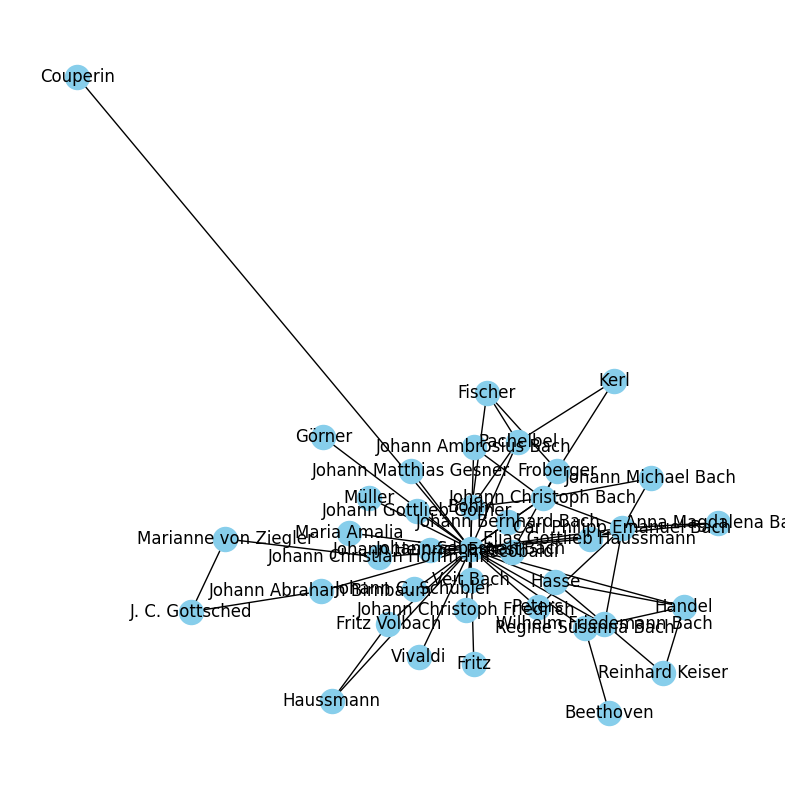

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, ax=ax, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [22]:
#!pip3 install pyvis
from pyvis.network import Network
net = Network(notebook=True, width='1000px', height='700px', bgcolor='#222222', font_color='white', cdn_resources='in_line')

node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')

net.from_nx(G, edge_scaling=True, show_edge_weights=True)
net.show('bach.html')

bach.html


## The most important character

In [23]:
degree_dict = nx.degree_centrality(G)
degree_dict

{'Johann Sebastian Bach': 0.7894736842105263,
 'Veit Bach': 0.02631578947368421,
 'Johann Christoph Bach': 0.18421052631578946,
 'Carl Philipp Emanuel Bach': 0.18421052631578946,
 'Johann Michael Bach': 0.05263157894736842,
 'Johann Bernhard Bach': 0.05263157894736842,
 'Johann Ambrosius Bach': 0.05263157894736842,
 'Froberger': 0.10526315789473684,
 'Fischer': 0.07894736842105263,
 'Pachelbel': 0.10526315789473684,
 'Böhm': 0.10526315789473684,
 'Handel': 0.10526315789473684,
 'Couperin': 0.02631578947368421,
 'Wilhelm Friedemann Bach': 0.10526315789473684,
 'Johann Gottlieb Görner': 0.02631578947368421,
 'Görner': 0.02631578947368421,
 'Anna Magdalena Bach': 0.05263157894736842,
 'Johann Heinrich Ernesti': 0.02631578947368421,
 'Johann Matthias Gesner': 0.02631578947368421,
 'Müller': 0.02631578947368421,
 'Maria Amalia': 0.02631578947368421,
 'Johann Christian Hoffmann': 0.05263157894736842,
 'Marianne von Ziegler': 0.05263157894736842,
 'J. C. Gottsched': 0.05263157894736842,
 'Joh

<Axes: >

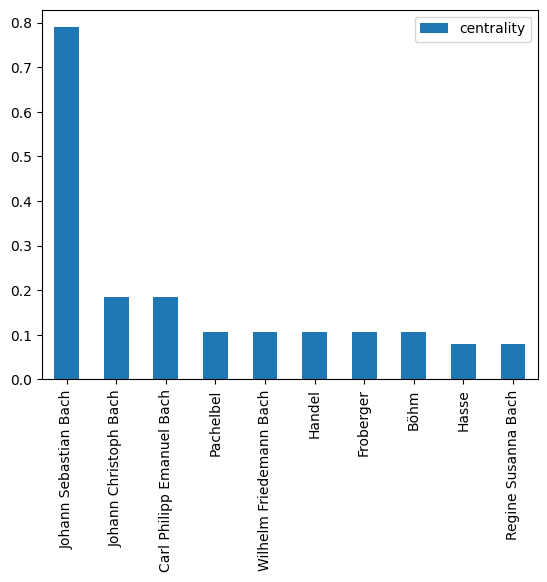

In [24]:
degree_df = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['centrality'])
degree_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

### Centralityで上位の人たちは誰？

Johann Christoph は Johann Sebastien の一番年上の兄。

```
In 1695, when Johann Sebastian was not quite ten years old, his father
died. He lost his mother at an earlier period.(47) So, being left an
orphan, he became dependent on his eldest brother, Johann Christoph,
Organist at Ohrdruf,(48) from whom he received his earliest lessons on the
Clavier.(49)
```

Wilhelm Friedemann は Johann Sebastien の１番年上の子供。
```
Bach and his eldest son, Wilhelm Friedemann.
```

Carl Philipp Emmanuel は Johann Sebastien の２番目に年上の子供。
```
His two eldest sons, Wilhelm Friedemann and Carl Philipp Emmanuel, were his most
distinguished pupils, not because he gave them better instruction than the
rest, but because from their earliest youth they were brought up amid good
music at home. 
```

Handelはバッハと同じ時代の有名なドイツ人音楽家でイギリスで成功。

<Axes: >

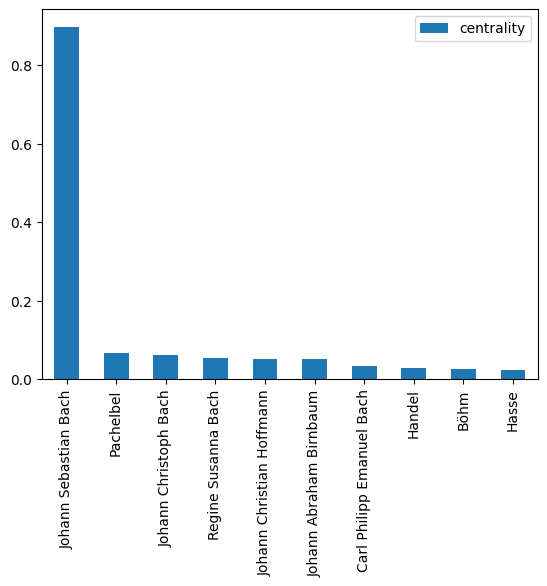

In [25]:
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict, orient='index', columns=['centrality'])
betweenness_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

<Axes: >

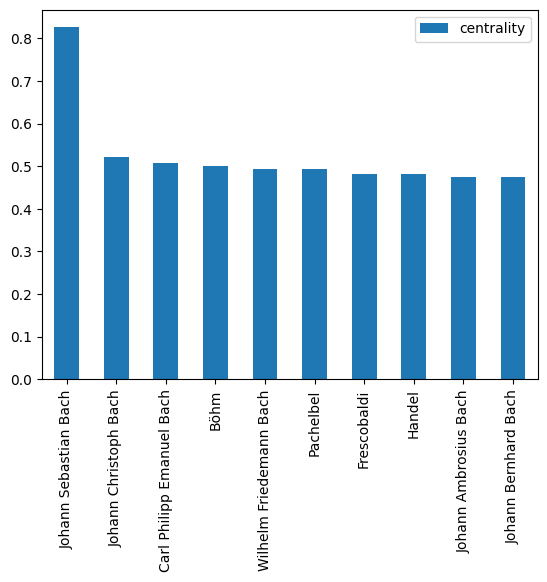

In [26]:
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict, orient='index', columns=['centrality'])
closeness_df.sort_values('centrality', ascending=False)[:10].plot(kind='bar')

## Community Detection

In [27]:
#!pip3 install community
from community import community_louvain

communities = community_louvain.best_partition(G)

In [28]:
nx.set_node_attributes(G, communities, 'group')

In [29]:
com_net = Network(notebook = True, width="1000px", height="700px", bgcolor='#222222', font_color='white', cdn_resources='in_line')
com_net.from_nx(G)
com_net.show_buttons(filter_=['physics'])
com_net.show("bach_communities.html")

bach_communities.html


## Exporting graph data to graphology.js

In [30]:
nodes = []
for node in G.nodes.data(data=True):
    nodes.append({'key': node[0], 'attributes': {'value': node[1]['size']}})
nodes

[{'key': 'Johann Sebastian Bach', 'attributes': {'value': 30}},
 {'key': 'Veit Bach', 'attributes': {'value': 1}},
 {'key': 'Johann Christoph Bach', 'attributes': {'value': 7}},
 {'key': 'Carl Philipp Emanuel Bach', 'attributes': {'value': 7}},
 {'key': 'Johann Michael Bach', 'attributes': {'value': 2}},
 {'key': 'Johann Bernhard Bach', 'attributes': {'value': 2}},
 {'key': 'Johann Ambrosius Bach', 'attributes': {'value': 2}},
 {'key': 'Froberger', 'attributes': {'value': 4}},
 {'key': 'Fischer', 'attributes': {'value': 3}},
 {'key': 'Pachelbel', 'attributes': {'value': 4}},
 {'key': 'Böhm', 'attributes': {'value': 4}},
 {'key': 'Handel', 'attributes': {'value': 4}},
 {'key': 'Couperin', 'attributes': {'value': 1}},
 {'key': 'Wilhelm Friedemann Bach', 'attributes': {'value': 4}},
 {'key': 'Johann Gottlieb Görner', 'attributes': {'value': 1}},
 {'key': 'Görner', 'attributes': {'value': 1}},
 {'key': 'Anna Magdalena Bach', 'attributes': {'value': 2}},
 {'key': 'Johann Heinrich Ernesti', 

In [31]:
edges = []
for edge in G.edges.data(data=True):
    edges.append({'key': f'{edge[0]}:{edge[1]}','source': edge[0], 'target': edge[1], 'attributes': {'value': edge[2]['value']}})
edges[:10]

[{'key': 'Johann Sebastian Bach:Veit Bach',
  'source': 'Johann Sebastian Bach',
  'target': 'Veit Bach',
  'attributes': {'value': 3}},
 {'key': 'Johann Sebastian Bach:Johann Bernhard Bach',
  'source': 'Johann Sebastian Bach',
  'target': 'Johann Bernhard Bach',
  'attributes': {'value': 3}},
 {'key': 'Johann Sebastian Bach:Johann Ambrosius Bach',
  'source': 'Johann Sebastian Bach',
  'target': 'Johann Ambrosius Bach',
  'attributes': {'value': 6}},
 {'key': 'Johann Sebastian Bach:Johann Christoph Bach',
  'source': 'Johann Sebastian Bach',
  'target': 'Johann Christoph Bach',
  'attributes': {'value': 4}},
 {'key': 'Johann Sebastian Bach:Handel',
  'source': 'Johann Sebastian Bach',
  'target': 'Handel',
  'attributes': {'value': 29}},
 {'key': 'Johann Sebastian Bach:Couperin',
  'source': 'Johann Sebastian Bach',
  'target': 'Couperin',
  'attributes': {'value': 34}},
 {'key': 'Johann Sebastian Bach:Carl Philipp Emanuel Bach',
  'source': 'Johann Sebastian Bach',
  'target': 'Carl

In [32]:
with open('../docs/graph_data.js', 'w', encoding='utf-8') as f:
    f.write(f'var nodes = {nodes};\n\nvar edges = {edges};')